# This tutorial generates a simulated data and uses EBtimecourse to find change points in the data.

In [1]:
rm(list=ls())
setwd("~/Documents/Research/Microarray_time_course/manuscript/EBtimecourse")
library(tensorflow)
use_python("/usr/local/bin/python3")
source("EBtimecourse.R")

Use Normal Normal-Gamma (NNG) model to generate a data matrix of 5000 genes by 8 time points, and numbers of replicates for the 8 time points are 3, 3, 3, 4, 2, 3, 3 respectively, so total columns are 24. In this simulation, we set P=0.2, which means 20% genes having change points and these genes are put in the top 20% rows of the data matrix. In the parameter matrix, it stores parameters of NNG to generate data. mu1 and mu2 stand for the latent means, sigma1 and sigma2 stand for variances of Normal distributions. n1, n2 and n3 stand for the length of the three homogeneous sequences, for example, if n1=2, n2=1, n3=5, it means the two change points are after 2nd and 3rd time point.

In [2]:
set.seed(0)

P=0.2 # proportion of genes to have change points
N=5000;

nDE=P*N; nEE=N-nDE;
cp_real_seq_index=1:nDE;
timePoint=8; # number of time points
replicate=c(3,3,3,4,2,3,3,3); # number of replicated of each time points, for example, this vector means 4th time point has 4 replicates and 5th time point has 2 replicates, the others have 3 replicates
Ti=sum(replicate); 

changePointTable = data.frame(matrix(NA, nrow=(timePoint-1)+(timePoint-1)*(timePoint-2)/2, ncol=3), stringsAsFactors=F)
colnames(changePointTable) = c("n1", "n2", "n3")
changePointTable[1:(timePoint-1),"n1"]=1:(timePoint-1)
changePointTable[1:(timePoint-1),"n2"]=(timePoint-1):1
changePointTable[1:(timePoint-1),"n3"]=0
combT = as.data.frame(t(combn(timePoint-1, 2)))
combT$V2 = combT$V2 - combT$V1
changePointTable[timePoint:nrow(changePointTable),c("n1","n2")]=combT
changePointTable[timePoint:nrow(changePointTable),"n3"]=timePoint-rowSums(changePointTable[timePoint:nrow(changePointTable),c("n1", "n2")])
combNumber = nrow(changePointTable)

ss=sample(1:nrow(changePointTable), P*N, replace=T)
n1=changePointTable[ss,"n1"]
n2=changePointTable[ss,"n2"]
n3=changePointTable[ss,"n3"]

n1=c(n1, rep(timePoint,nEE)); n2=c(n2, rep(0, nEE)); n3=c(n3, rep(0, nEE));
mu0=0; kappa0=0.1; alpha0=1; beta0=10;
lambda = rgamma(N*2, shape=alpha0, rate=beta0)
mu = rnorm(N*2,mean=mu0,sd=1/sqrt(kappa0*lambda))
lambda = matrix(lambda, ncol=2)
mu = matrix(mu, ncol=2)
sigma = 1/sqrt(lambda)
parameter=data.frame(mu, sigma, n1=n1, n2=n2, n3=n3)
colnames(parameter)=c("mu1", "mu2", "sigma1", "sigma2", "n1", "n2", "n3")

gene.de=t(apply(parameter[1:nDE,],1, function(x) 
  c(rnorm(sum(replicate[1:x[5]]), mean=x[1], sd=x[3]), rnorm(sum(replicate[(x[5]+1):(x[5]+x[6])]), mean=x[2], sd=x[4]),
    rnorm(sum(replicate[-c(1:(x[5]+x[6]))]), mean=x[1], sd=x[3]))))
gene.ee=t(apply(parameter[(nDE+1):N,],1, function(x) c(rnorm(Ti, mean=x[1], sd=x[3]))))

gene.exp=rbind(gene.de, gene.ee)
                
dim(gene.exp)
head(gene.exp)
head(parameter)

[1] 5000   24

1,-3.285078,8.610306,-1.063723,4.507473,10.298762,-11.006909,8.427543,8.820394,-1.017102,-2.39364707,⋯,13.035425,-3.200825,17.7510469,11.6067653,11.054699,-4.053944,-17.6267168,5.598914,4.562427,13.727485
2,-30.507551,-36.736260,-36.755772,-39.199696,-36.274134,-37.825426,-38.685185,-35.224131,-27.932281,-27.60923338,⋯,-44.809375,-56.078918,-40.2316860,-61.9481733,-53.330813,-29.548367,-46.4159059,-29.333214,-40.821844,-26.554135
3,-3.163523,23.367683,20.192805,19.117501,9.180919,-1.361957,9.334935,5.762768,16.349196,-0.09766263,⋯,-2.908225,5.095483,-0.4581213,0.8090759,2.130251,-4.179913,-0.6558008,-0.813946,-2.716823,-3.093558
4,-33.963390,-31.652741,-38.304498,-33.927841,-29.932675,-40.371206,-44.315181,-29.801886,-38.421447,-36.57641001,⋯,-48.664259,-44.747627,-32.5573981,-33.3400686,-29.737561,-29.696431,-27.1448200,13.093568,9.809801,12.987329
5,5.003540,4.084305,1.072370,-13.773888,-8.944535,-14.182147,-11.992283,-9.283971,-11.596403,-10.72087649,⋯,-11.495622,-11.068810,-9.5528234,-11.0987058,-12.494780,-9.463464,-10.2732554,-10.344919,-12.627282,-13.040813
6,-3.721470,-3.020583,-2.376342,-8.049196,-7.420418,-5.052240,-6.111652,-9.623249,-7.386672,-6.87768239,⋯,-4.512848,-5.043418,-6.3980718,-5.8141677,-7.392566,-4.411089,-6.5736518,-2.676943,-6.315166,-5.732960


,mu1,mu2,sigma1,sigma2,n1,n2,n3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.918833,12.142141,7.832406,5.491346,2,1,5
2,-34.407756,-42.699498,5.275633,11.369061,4,3,1
3,7.570016,-1.200191,8.021654,2.573962,4,4,0
4,-32.156221,12.478081,5.203901,3.767282,7,1,0
5,3.975433,-11.047866,2.794193,2.461673,1,7,0
6,-3.978626,-6.008522,2.849007,2.129641,2,6,0


Run EBtimecourse

In [3]:
ptm <- proc.time()
result = EBtimecourse(exp.dat = gene.exp, timepoint = timePoint, replicate = replicate, FDR=0.1, verbose=F)
print(proc.time() - ptm)

19663 369603.891139287

Max delta ll: 0



[1] "Converge params:"
$P
[1] 0.8003107

$mu0
[1] -0.06004291

$kappa0
[1] 0.1014236

$alpha0
[1] 1.013126

$beta0
[1] 10.035

    user   system  elapsed 
1355.718  224.624  318.823 


Summarize the sensitivity and FDR for Q1 and Q2

In [4]:
Q1_sensitivity = sum(result$cp.index %in% cp_real_seq_index)/nDE
Q1_FDR = sum(!(result$cp.index %in% cp_real_seq_index))/length(result$cp.index)
cp_position_correct_numer = 0
cp_position_not_correct_numer = 0
for(i in 1:nrow(result$cp.position)) {
  if(parameter[result$cp.position$SeqID[i],"n1"]==result$cp.position[i, "n1"] & parameter[result$cp.position$SeqID[i],"n2"]==result$cp.position[i, "n2"])
    cp_position_correct_numer=cp_position_correct_numer+1
  else
    cp_position_not_correct_numer = cp_position_not_correct_numer+1
}
Q2_sensitivity=cp_position_correct_numer/nDE
Q2_FDR=cp_position_not_correct_numer/nrow(result$cp.position)

print(Q1_sensitivity)
print(Q1_FDR)
print(Q2_sensitivity)
print(Q2_FDR)

[1] 0.777
[1] 0.1038062
[1] 0.705
[1] 0.09731114


Plot heatmaps of different change-point patterns

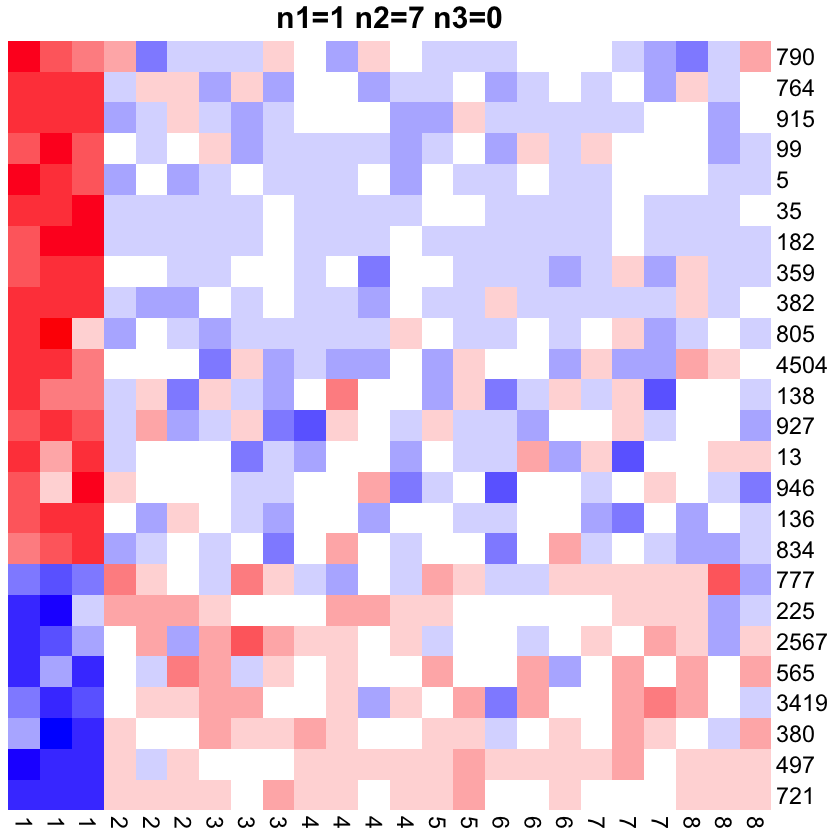

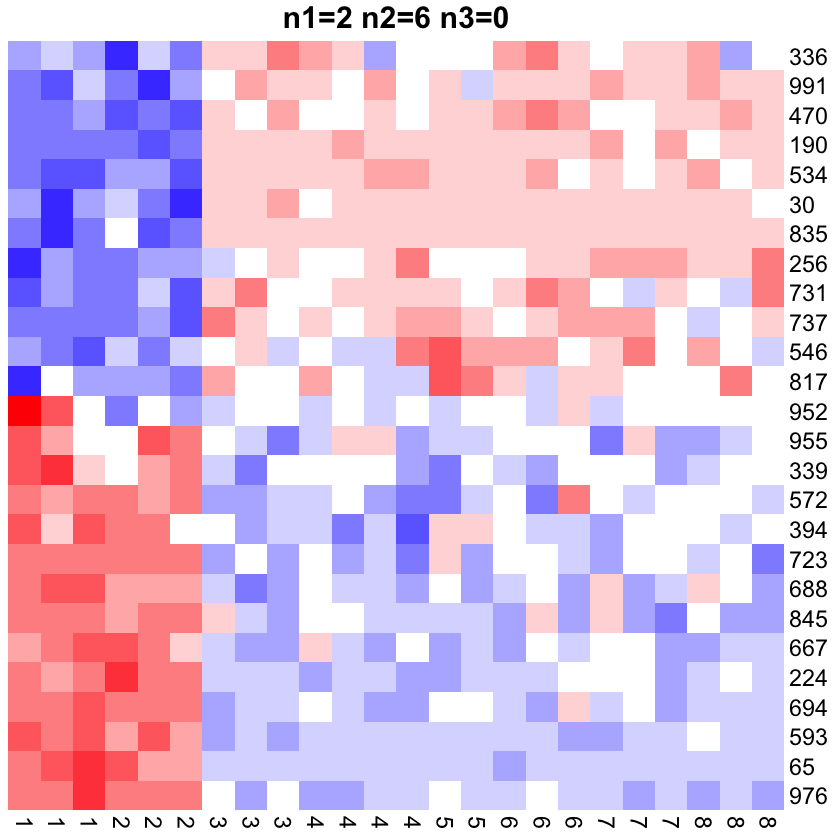

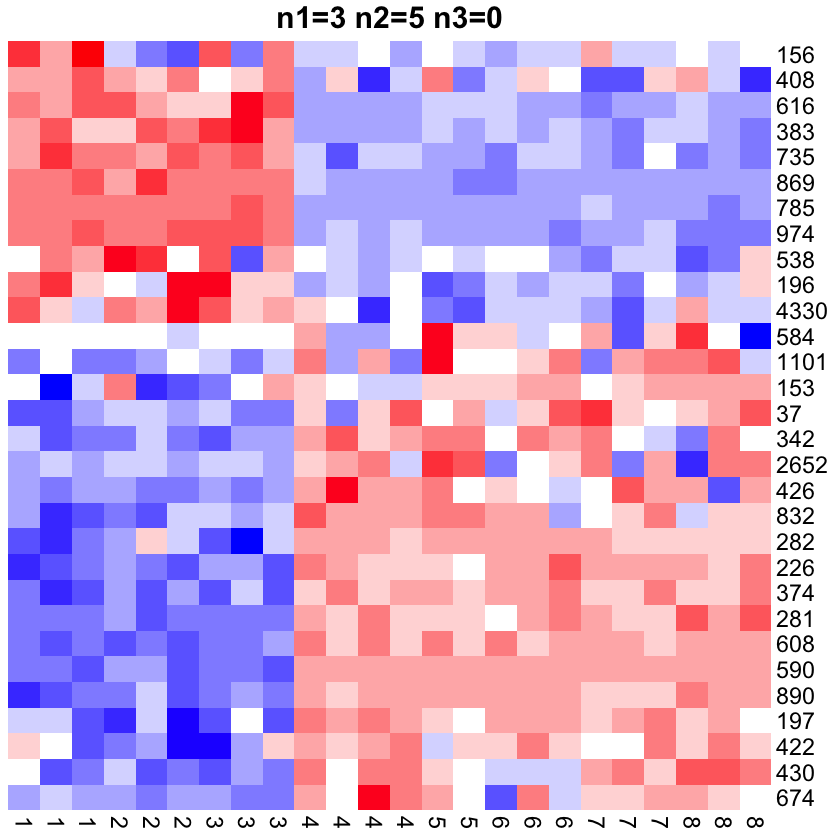

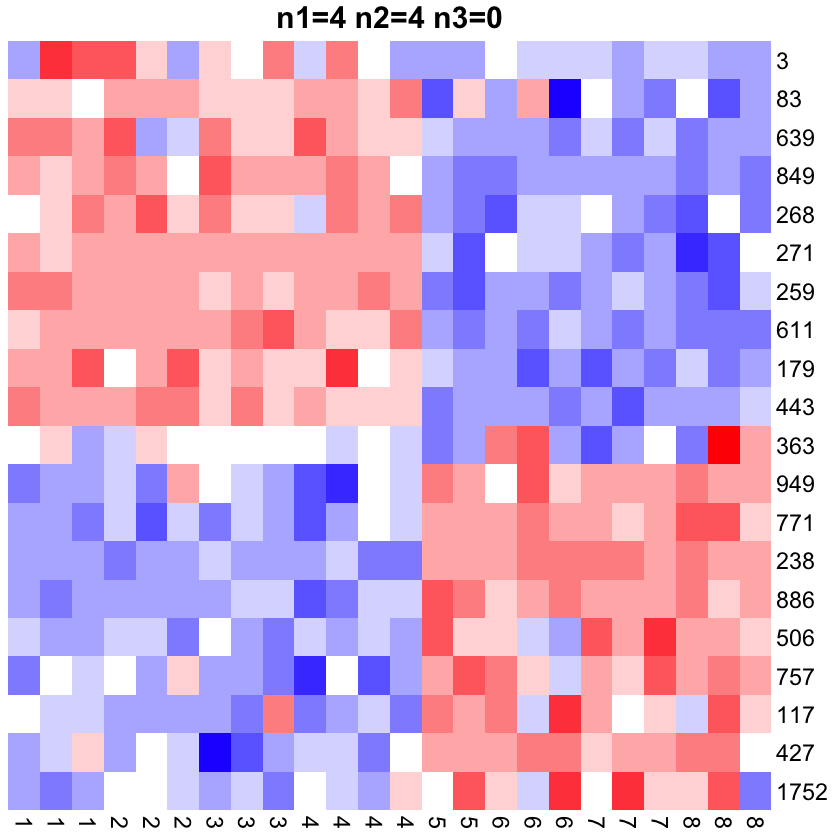

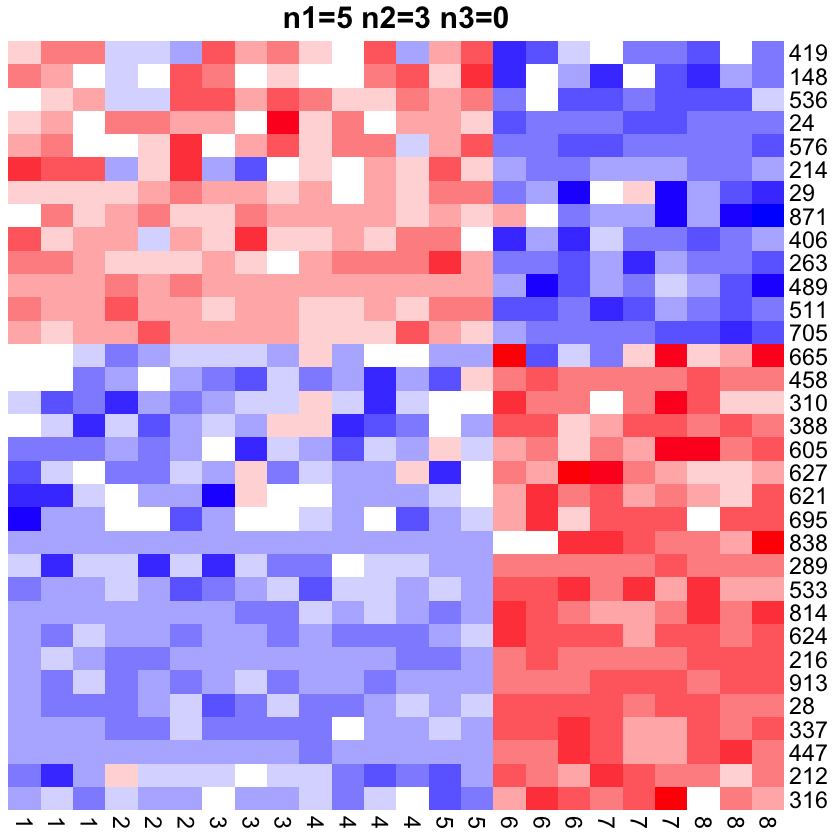

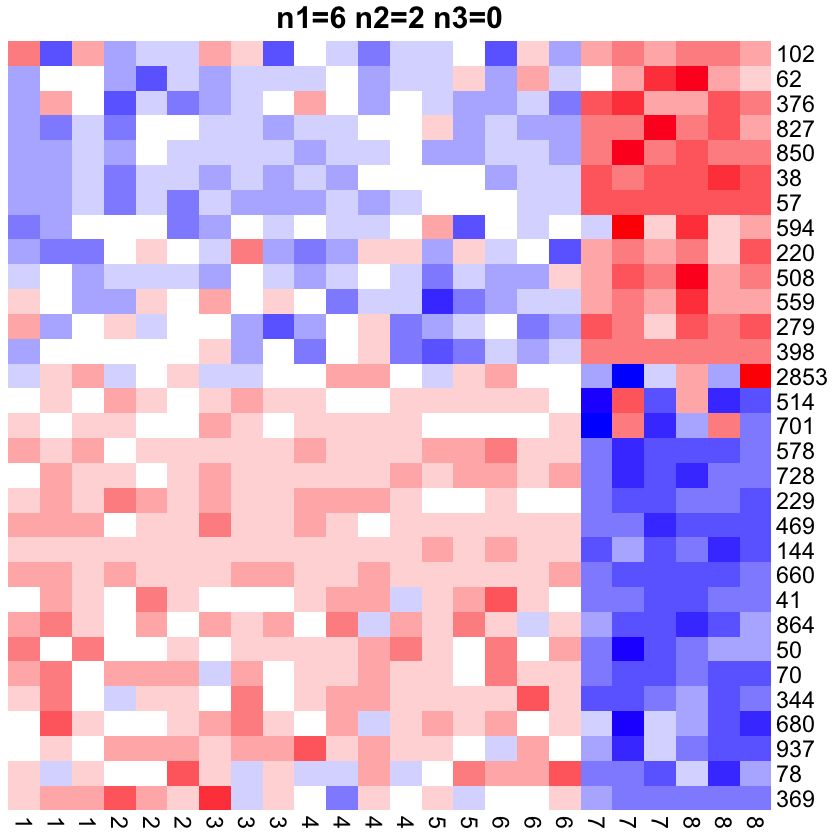

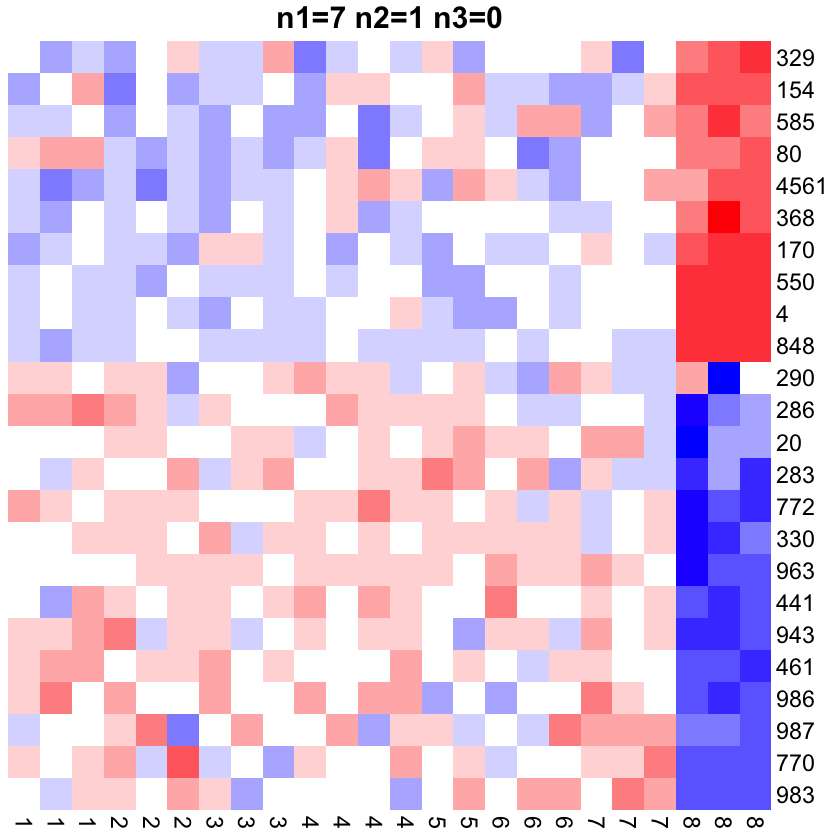

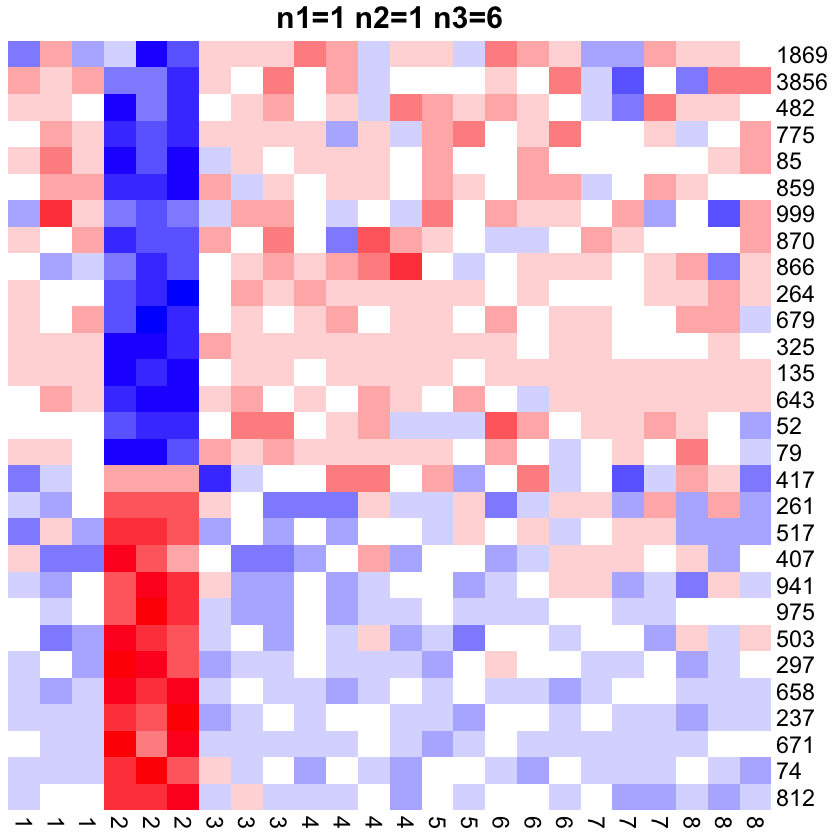

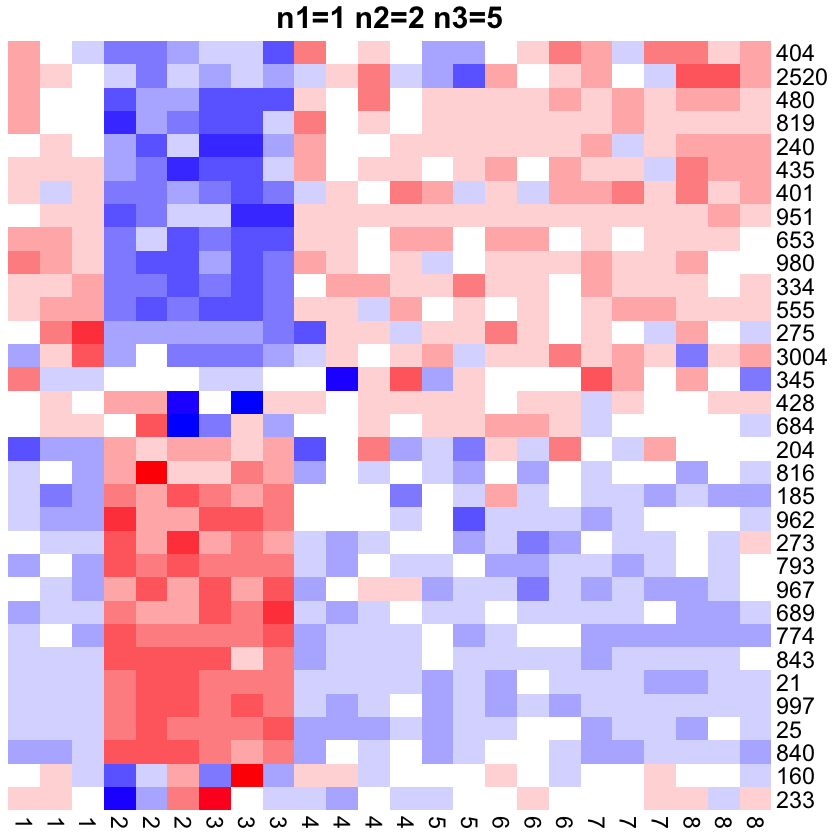

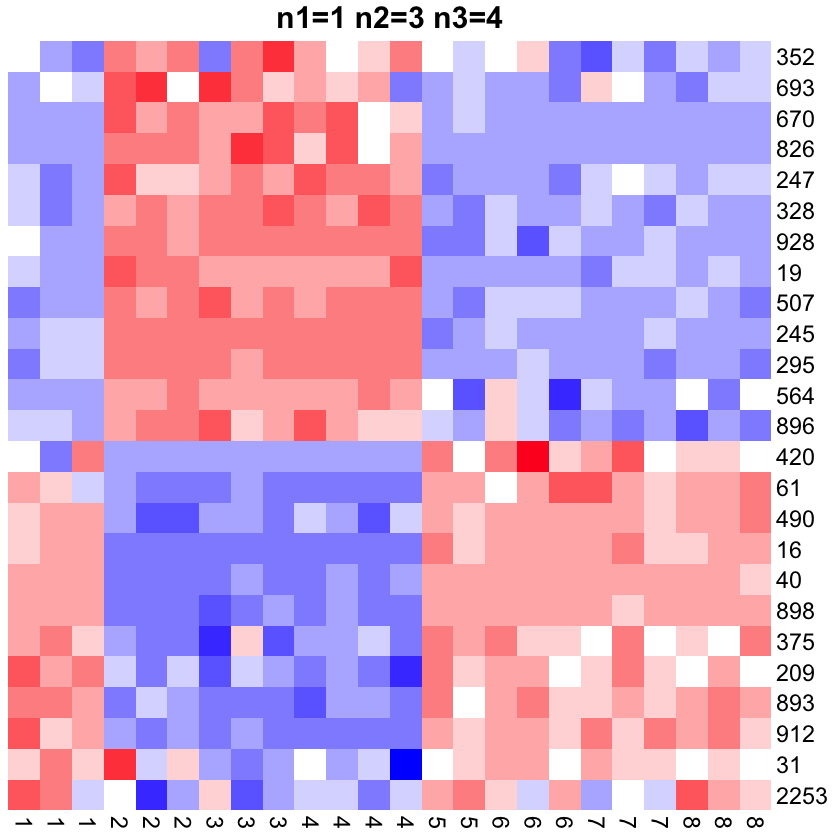

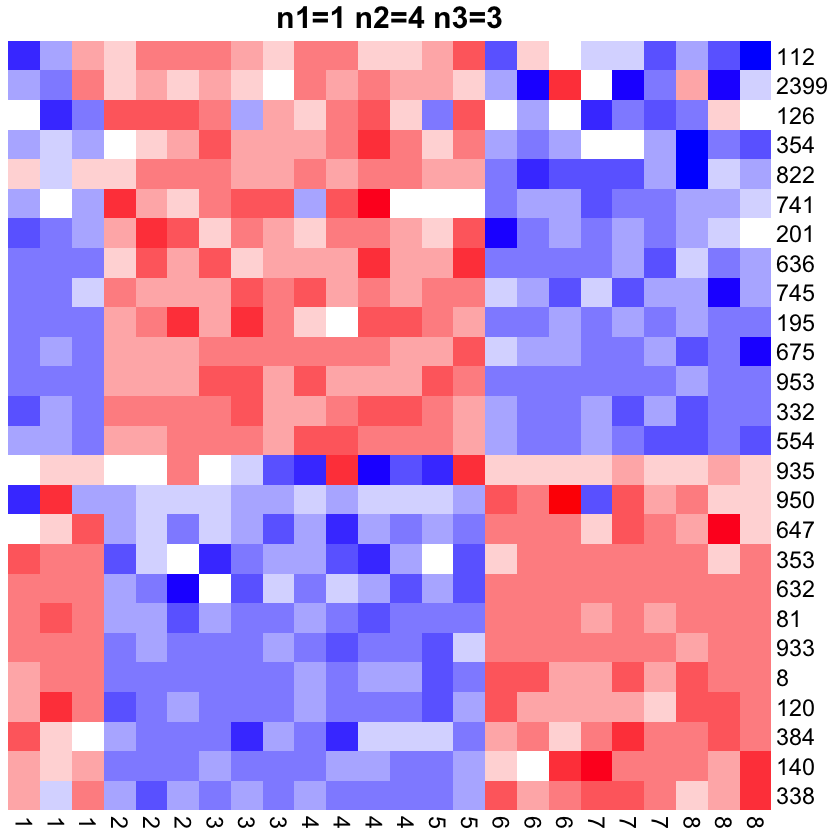

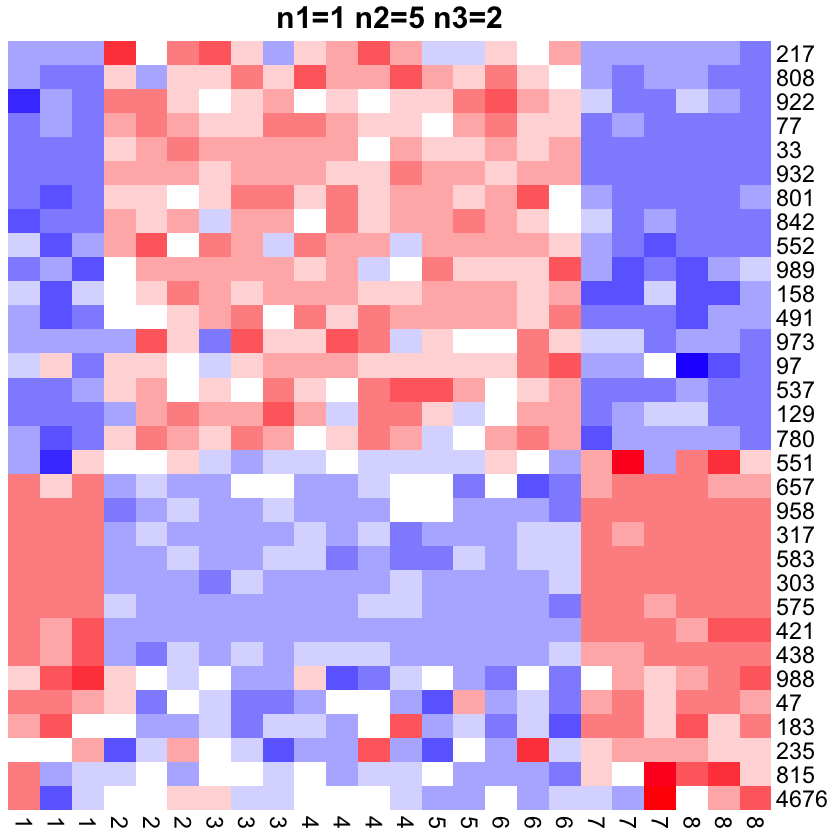

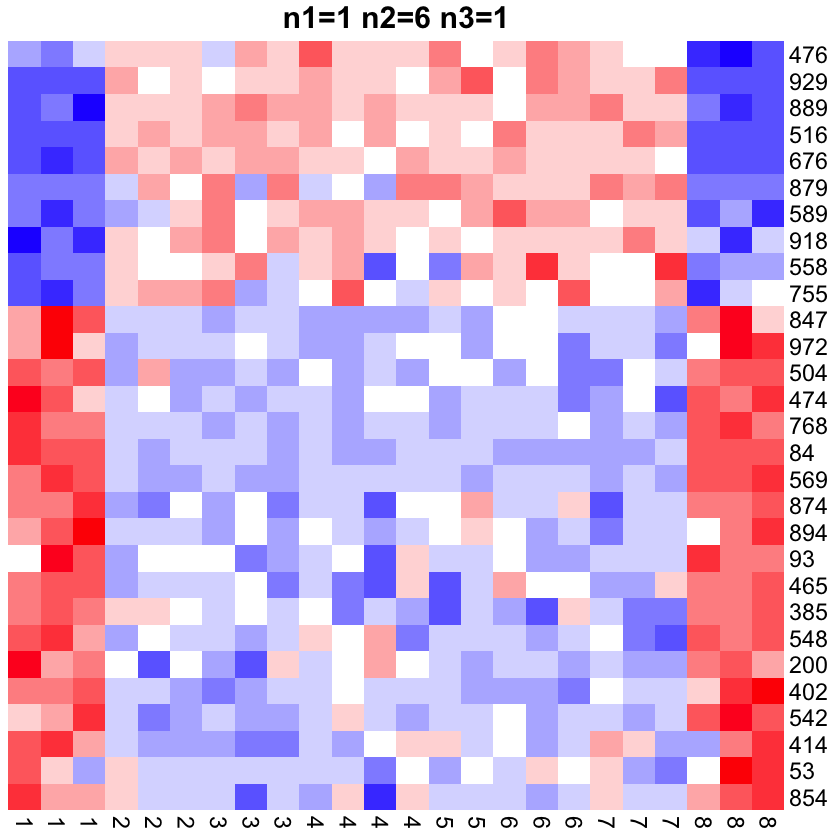

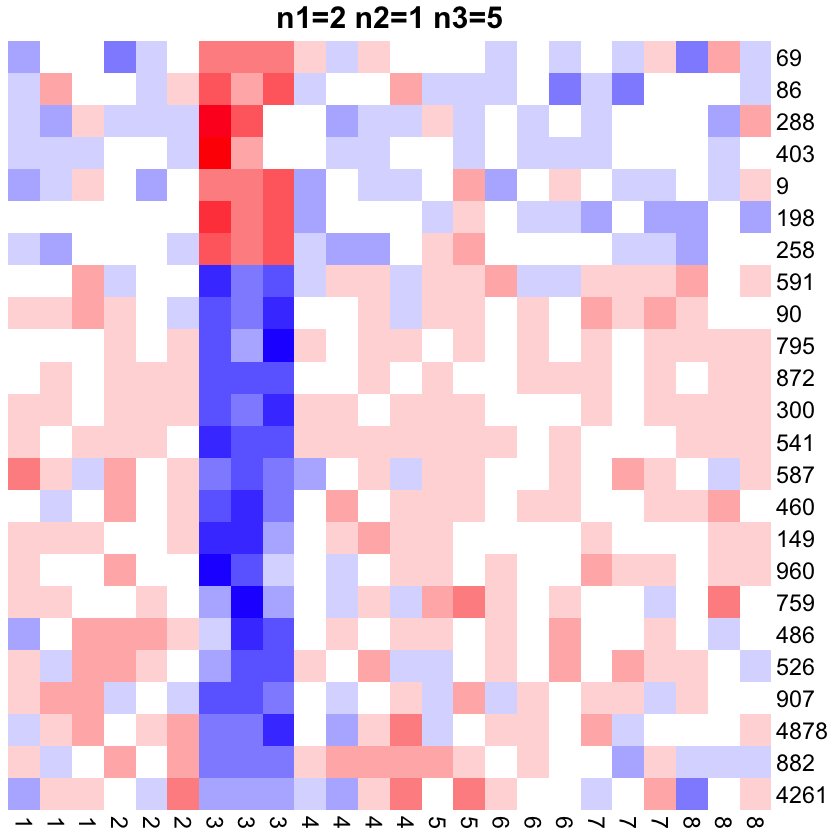

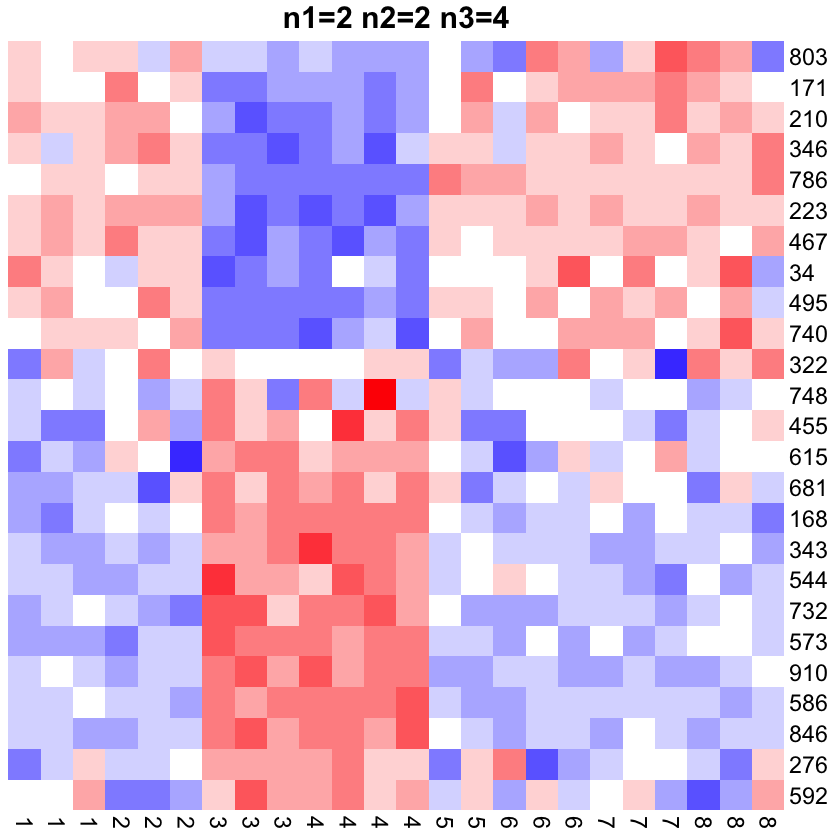

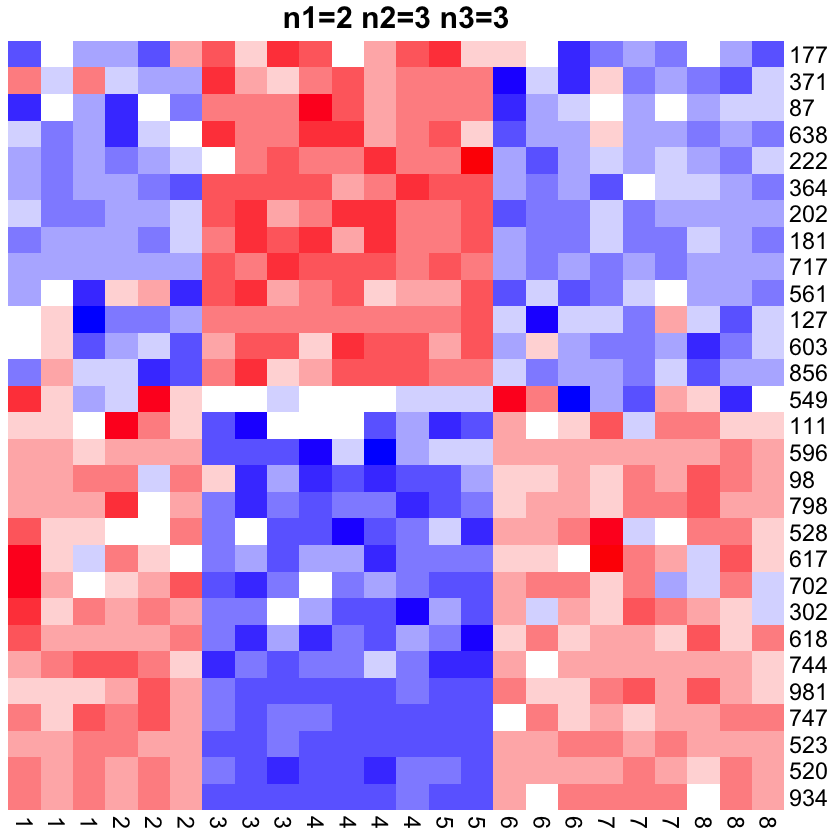

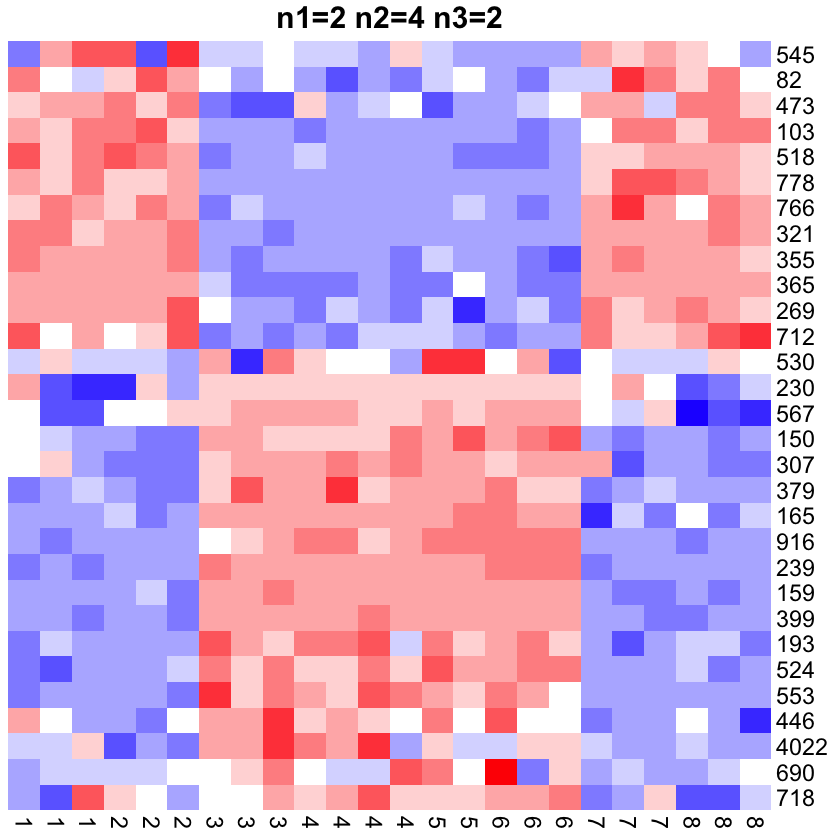

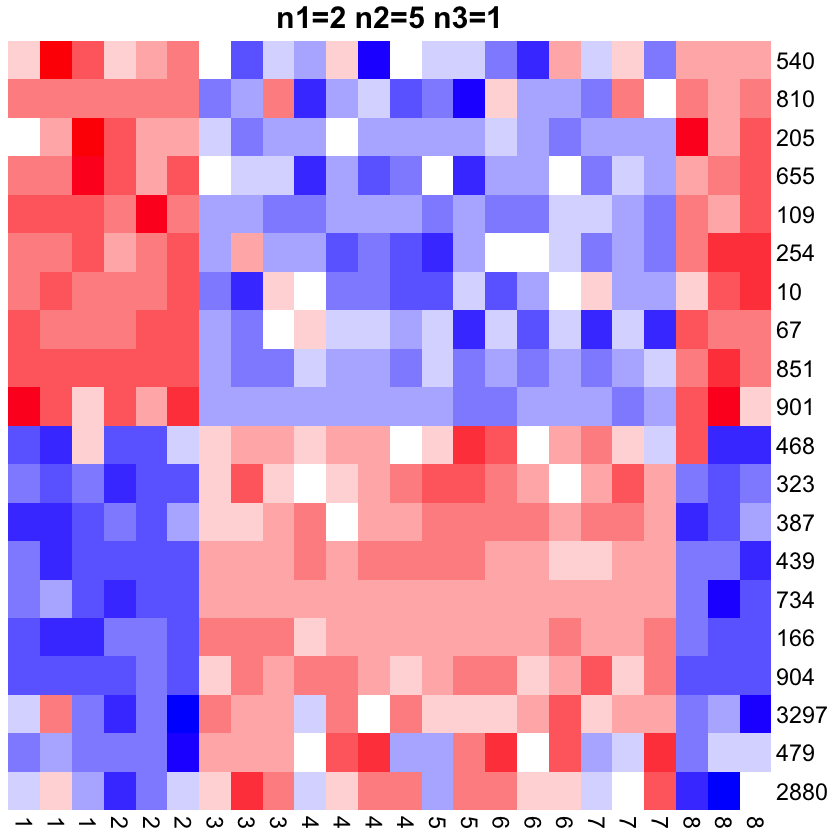

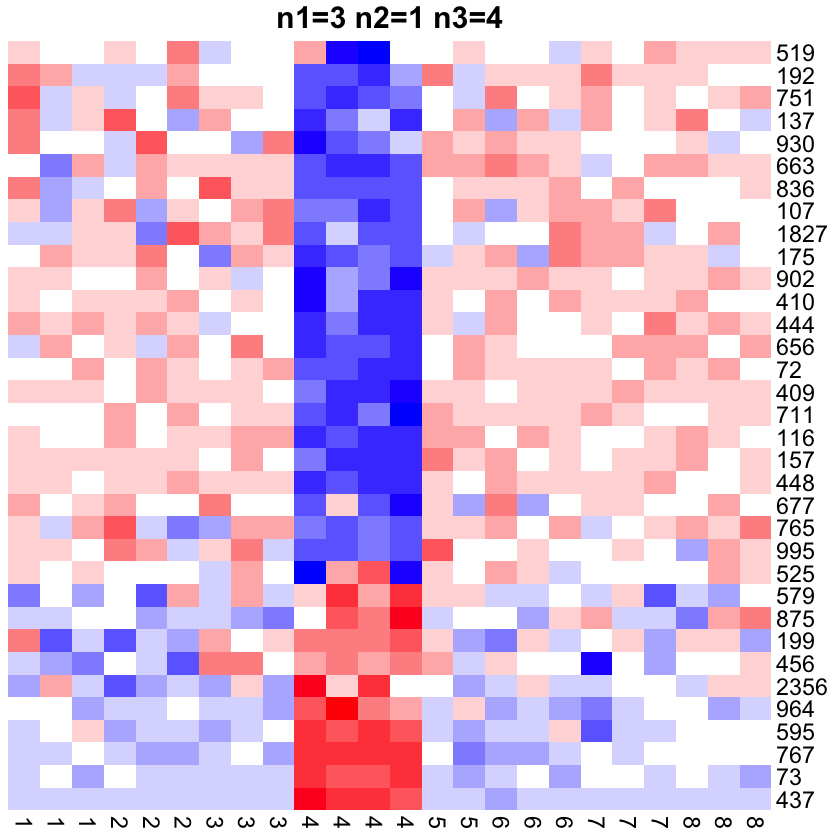

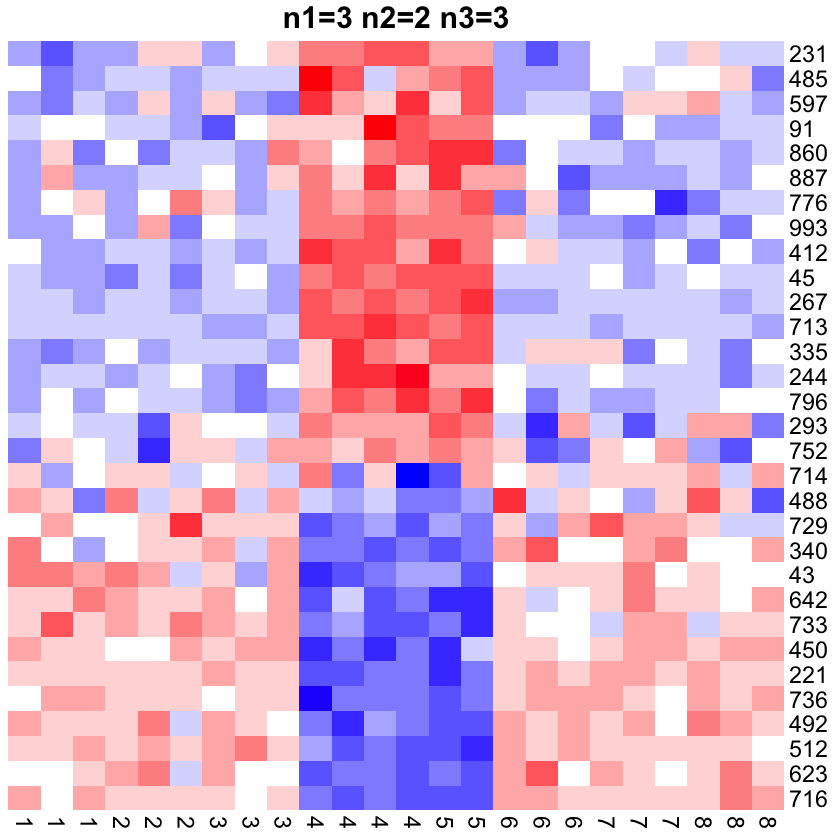

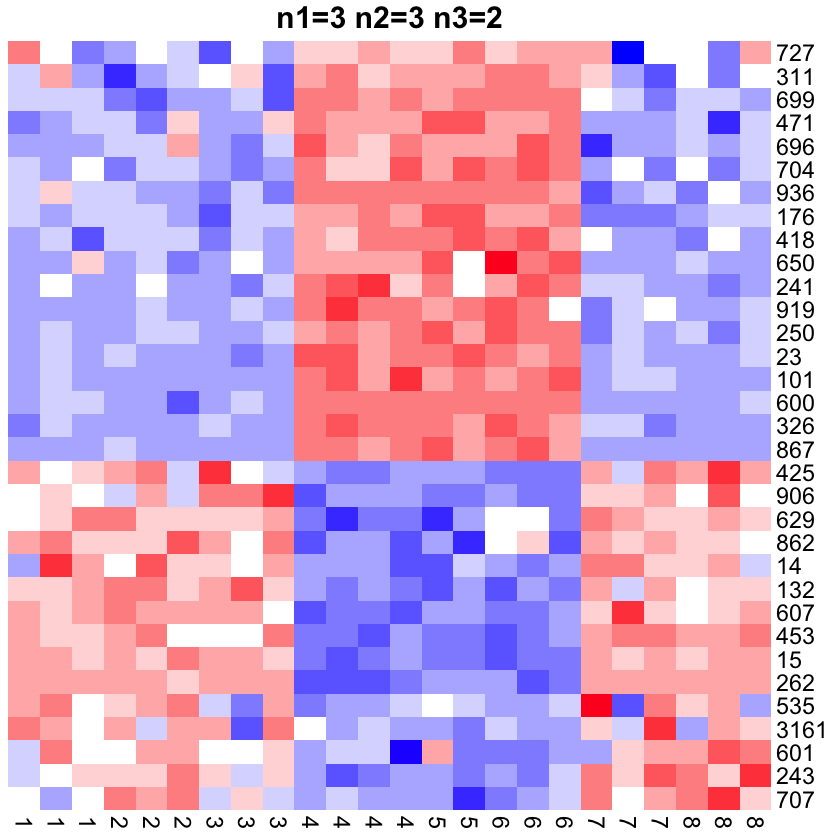

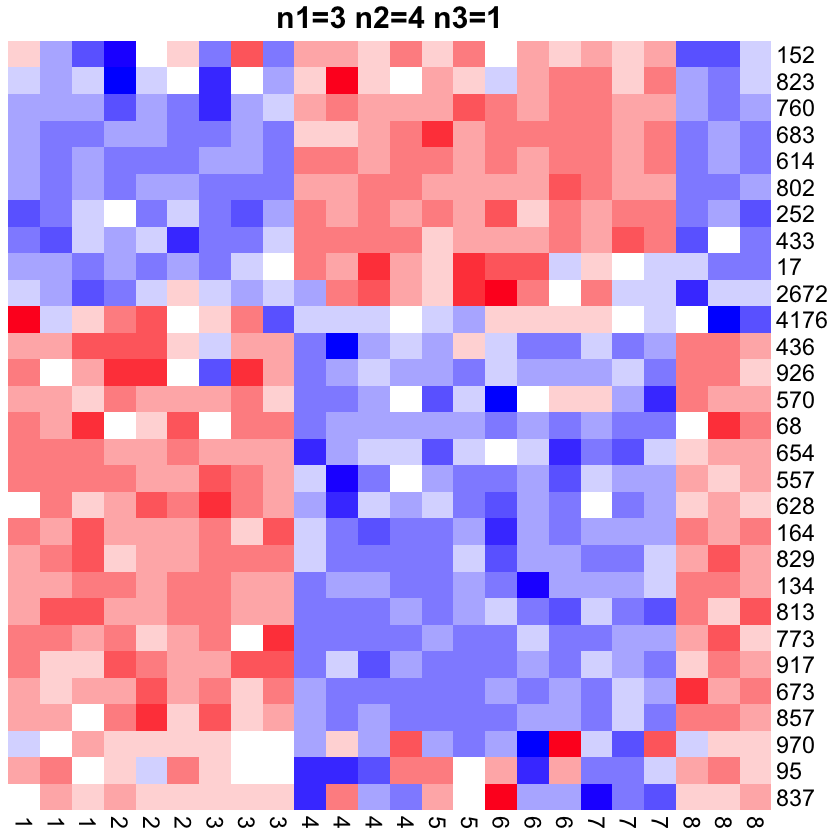

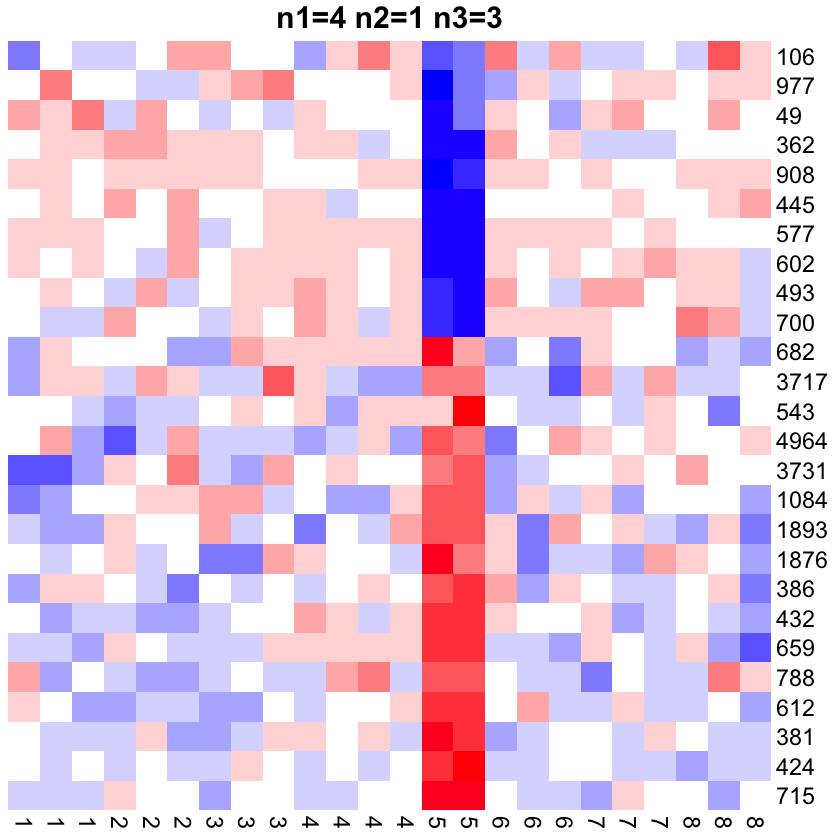

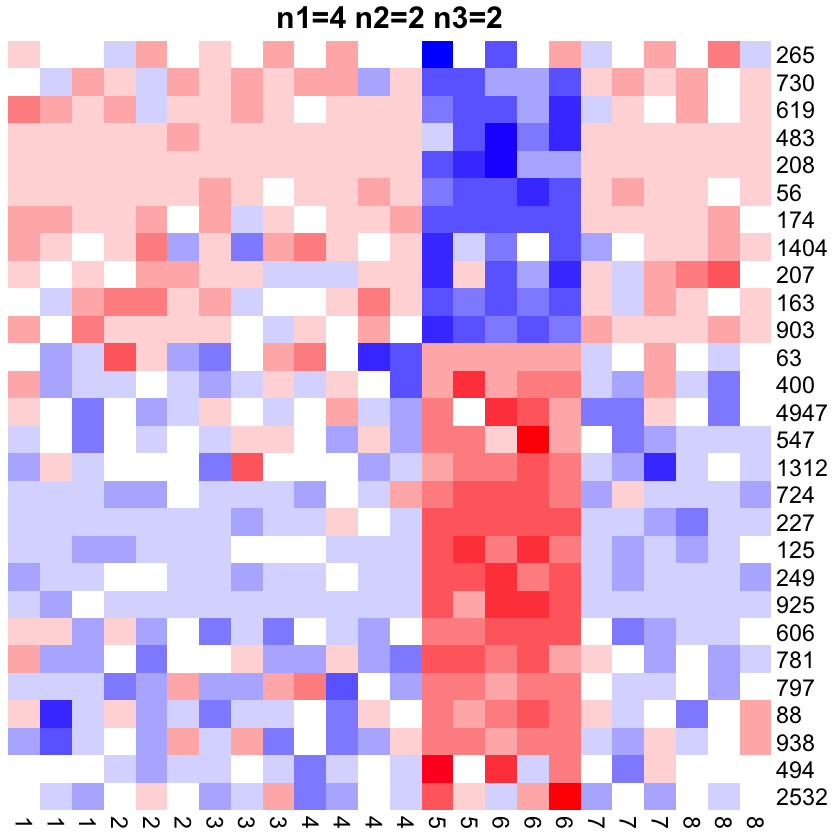

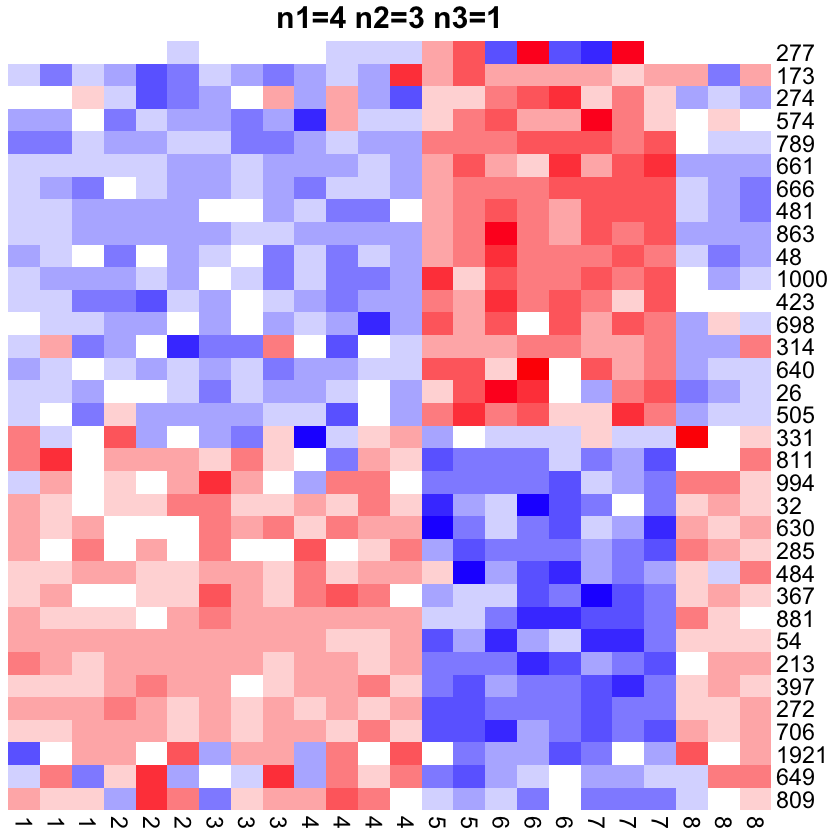

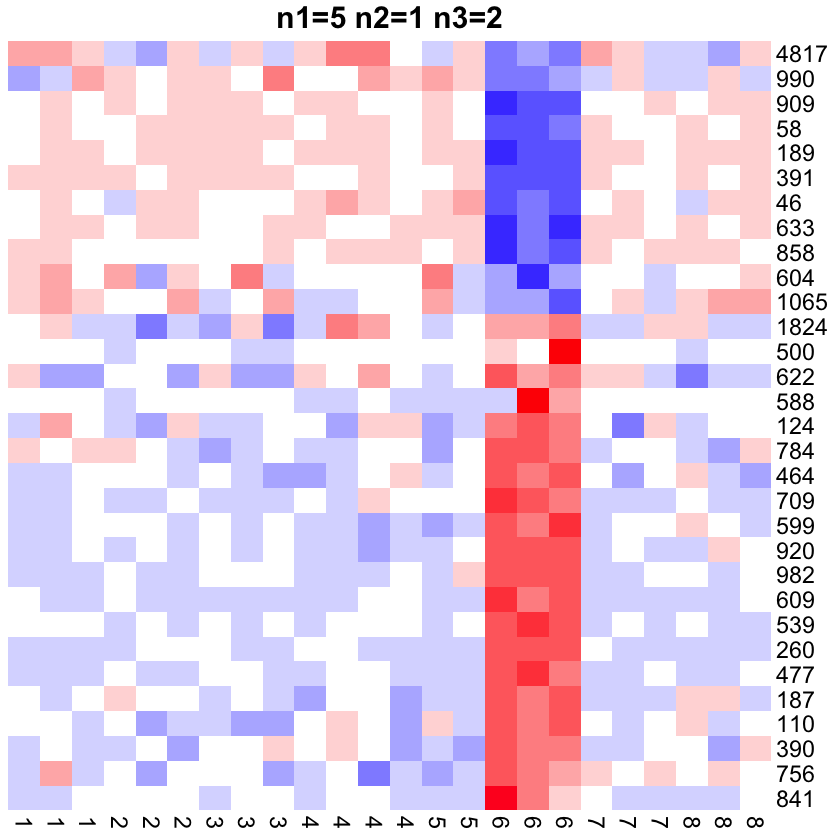

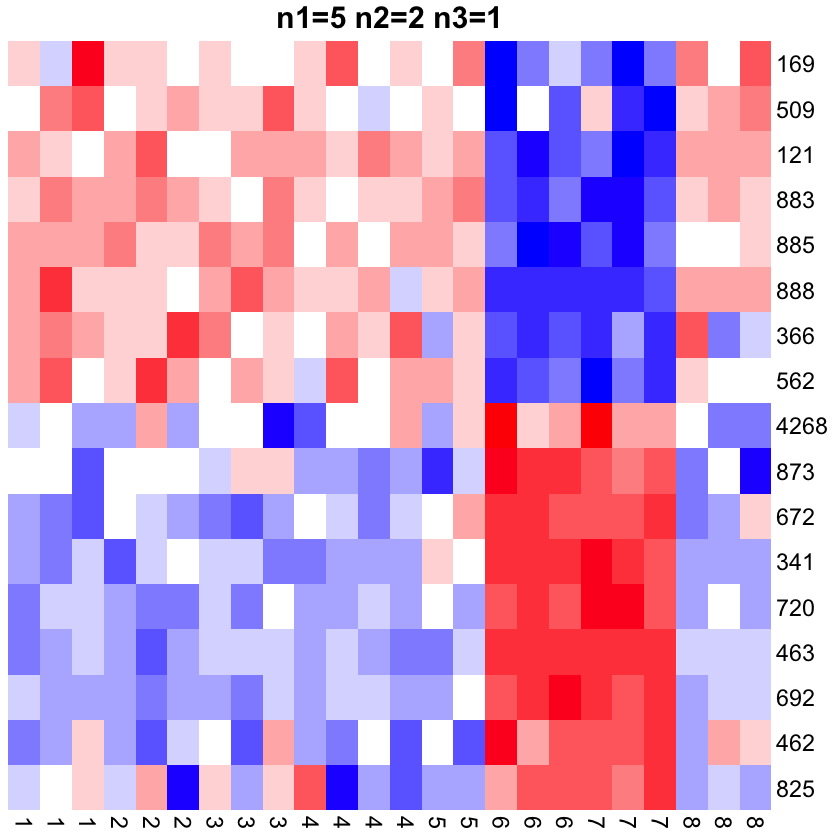

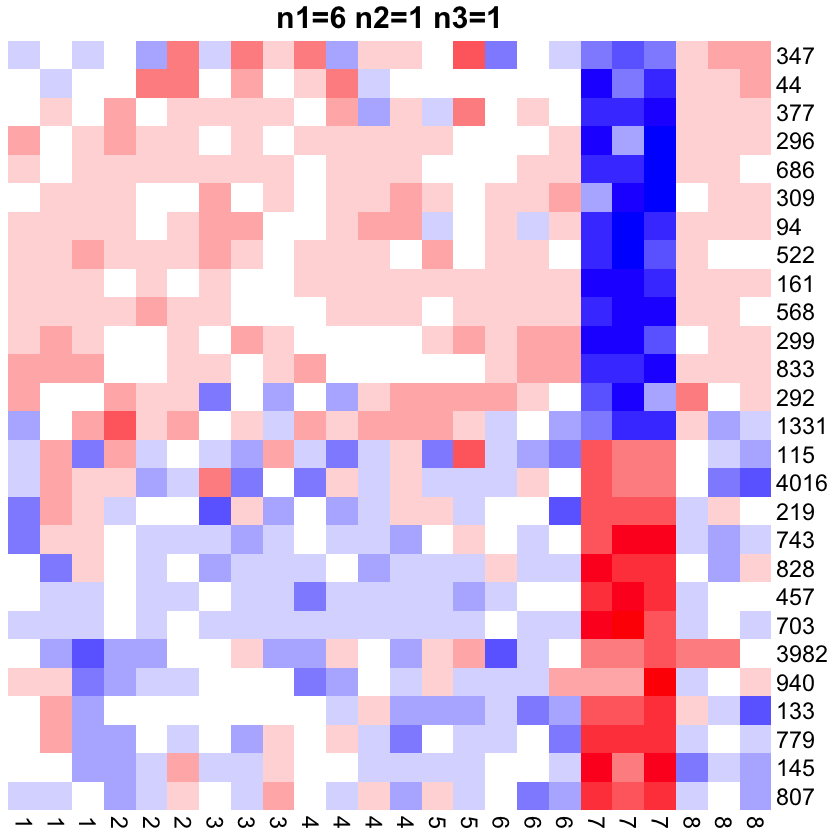

In [5]:
library(pheatmap)
cp.position = result$cp.position

for(i in 1:nrow(changePointTable)) {
  seqID = c()
  for(j in 1:nrow(cp.position)) {
    if(cp.position[j, "n1"]==changePointTable[i, "n1"] & cp.position[j, "n2"]==changePointTable[i, "n2"])
      seqID = c(seqID, cp.position[j, "SeqID"])
  }
  if(length(seqID)==0) next;
  h.data = matrix(gene.exp[seqID,], nrow=length(seqID))
  h.data = t(scale(t(h.data), center=T, scale=T))
  rownames(h.data) = rownames(gene.exp)[seqID]
  colnames(h.data) = rep(1:timePoint, times=replicate)
  h.scale = max(abs(max(h.data)), abs(min(h.data)))
  n1 = changePointTable[i, "n1"]
  n2 = changePointTable[i, "n2"]
  n3 = changePointTable[i, "n3"]
  
 
  pheatmap(h.data, clustering_distance_rows="correlation", clustering_method="complete",
     legend=F, treeheight_row=0, border_color=NA, fontsize=14,
     show_colnames=T, show_rownames=T, cluster_cols=F, cluster_rows=T,
     breaks=seq(from=-h.scale,to=h.scale,len=15+1), color = colorRampPalette(c("blue", "white", "red"))(15),
     main=paste("n1=",n1," n2=",n2," n3=",n3,sep=""))
}